<a href="https://colab.research.google.com/github/sean25benhur/catsvsdogs/blob/master/Cats_vs_Dogs_MobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classifying Cats or Dogs using Transfer Learning**
  In this notebook,we will classify cats or dogs using a Pretrained MobileNet model,to get a 99% accuracy!

Install the required Packages!

In [2]:
!pip install -U tensorflow_datasets

     |████████████████████████████████| 3.3MB 25kB/s 
  Found existing installation: tensorflow-datasets 2.1.0
    Uninstalling tensorflow-datasets-2.1.0:
      Successfully uninstalled tensorflow-datasets-2.1.0


Import the necessary Packages that are required

In [0]:
import time
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from tensorflow.keras import layers

**Loading the datasets**


Load the data and split it into train and validation sets!!

In [4]:
(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs',
    split = ('train[:80%]', 'train[80%:]'),
    with_info = True,
    as_supervised = True
)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteH1QNWA/cats_vs_dogs-train.tfrecord
Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


# **Preprocessing the data**

In [0]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image,label

num_examples = info.splits['train'].num_examples

BATCH_SIZE = 32
IMAGE_RES = 224

train_batches = train_examples.cache().shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

To use a pretrained model,we should install the tensorflow-hub package,in this we are going to use Google's mobilenet for getting better results

In [6]:
!pip install tensorflow_hub

# **Add the URL for mobilenet pretrained model!!**

In [0]:
import tensorflow_hub as hub
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape = (IMAGE_RES,IMAGE_RES,3))

In [0]:
feature_extractor.trainable = False

Train the pretrained model!!,just change the output layer,in this we are classifying cats vs dogs, as it is a binary classification,there are only two output layers

In [9]:
model = tf.keras.Sequential([
                             feature_extractor,
                             layers.Dense(2)                           
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


# **Compile the model**


In [10]:
model.compile(
    optimizer = 'adam',
    loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
EPOCHS = 3
history = model.fit(train_batches,
                    epochs = EPOCHS,
                    validation_data = validation_batches)

Epoch 1/3
582/582 [==============================] - 33s 56ms/step - loss: 0.0532 - accuracy: 0.9816 - val_loss: 0.0308 - val_accuracy: 0.9886
Epoch 2/3
582/582 [==============================] - 21s 35ms/step - loss: 0.0298 - accuracy: 0.9897 - val_loss: 0.0293 - val_accuracy: 0.9901
Epoch 3/3
582/582 [==============================] - 20s 35ms/step - loss: 0.0244 - accuracy: 0.9916 - val_loss: 0.0315 - val_accuracy: 0.9893


We can see that it has a nearly 99% accuracy on validation examples

In [11]:
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

Predict for the next batch of images!!

In [12]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['cat', 'cat', 'cat', 'dog', 'cat', 'cat', 'dog', 'dog', 'cat',
       'cat', 'cat', 'cat', 'dog', 'cat', 'dog', 'dog', 'cat', 'dog',
       'dog', 'cat', 'dog', 'dog', 'dog', 'dog', 'dog', 'cat', 'dog',
       'dog', 'cat', 'dog', 'dog', 'cat'], dtype='<U3')

In [13]:
print('Labels:', label_batch)
print('Predicted_labels:', predicted_ids)

Labels: [0 0 0 1 0 0 1 1 0 0 0 0 1 0 1 1 0 1 1 0 1 1 1 1 1 0 1 1 0 1 1 0]
Predicted_labels: [0 0 0 1 0 0 1 1 0 0 0 0 1 0 1 1 0 1 1 0 1 1 1 1 1 0 1 1 0 1 1 0]


# Pictorial Represantation
Now, let's plot the predictions using matplotlib,let's label **Blue** color for correct images and **Red** for incorrect images

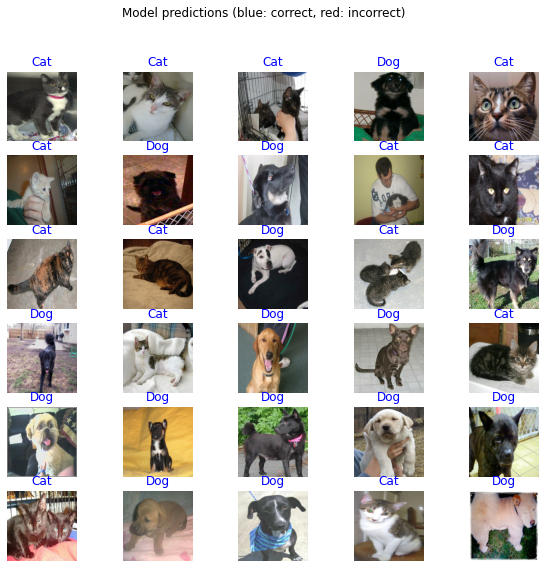

In [15]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_= plt.suptitle("Model predictions (blue: correct, red: incorrect)")


We can see that it gets better results,as it classifies all the images accurately

# Save the model

Save the model in h5 format to use it later!!

In [16]:
t = time.time()

export_path_keras = "./{}.h5".format(int(t))
print(export_path_keras)

model.save(export_path_keras)

./1587651942.h5


In [17]:
!ls

1587651942.h5  sample_data


Reload the saved model!!

In [18]:
reloaded = tf.keras.models.load_model(
  export_path_keras, 
  # `custom_objects` tells keras how to load a `hub.KerasLayer`
  custom_objects={'KerasLayer': hub.KerasLayer})

reloaded.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [20]:
(abs(result_batch - reloaded_result_batch)).max()

0.0

Compile the pretrained model!

In [21]:
EPOCHS = 3
history = reloaded.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/3
582/582 [==============================] - 21s 37ms/step - loss: 0.0216 - accuracy: 0.9927 - val_loss: 0.0315 - val_accuracy: 0.9908
Epoch 2/3
582/582 [==============================] - 21s 35ms/step - loss: 0.0210 - accuracy: 0.9927 - val_loss: 0.0352 - val_accuracy: 0.9880
Epoch 3/3
582/582 [==============================] - 21s 35ms/step - loss: 0.0164 - accuracy: 0.9946 - val_loss: 0.0362 - val_accuracy: 0.9880


This model also gets an accuracy of 99%

# Saving the reloaded model
Save the trained reloaded model,to export it later

In [22]:
t = time.time()

export_path_sm = "./{}".format(int(t))
print(export_path_sm)

tf.saved_model.save(model, export_path_sm)

./1587652107
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: ./1587652107/assets


INFO:tensorflow:Assets written to: ./1587652107/assets


In [23]:
!ls {export_path_sm}

assets	saved_model.pb	variables
